# Improting Libraries

In [1]:
# Generic Libraries
import re
import pandas as pd # For creating dataframes of extracted information
import bs4
import requests
from tqdm import tqdm

# NLP Specific Libraries
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Libraries for displaying Knowledge Graph
import networkx as nx
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Reading The Dataset

In [2]:

df = pd.read_csv("/content/McDonald_s_Reviews.csv", encoding='ISO-8859-1')

### Extracting states and regions from Address column

In [3]:
import re

def extract_state_from_address(address):
    # Define a regular expression pattern to match the state abbreviation
    state_pattern = re.compile(r'\b(?!US)([A-Z]{2})\b')

    # Use the pattern to find the state in the address
    match = state_pattern.search(address)

    # If a match is found, return the state abbreviation
    if match:
        return match.group(0)
    else:
        return None

# Apply the function to the 'store_address' column and store the results in a new column 'state'
df['state'] = df['store_address'].apply(extract_state_from_address)

df.drop(columns = ['category', 'store_name', 'store_address', 'reviewer_id', 'rating_count', 'review_time'], axis = 1, inplace = True)


# Mapping the states
def map_states(x):
  if x in ['PA', 'NY', 'NJ', 'VA']:
    return 'East'
  elif x in ['TX', 'IL']:
    return 'Central'
  return 'West'

df['region'] = df['state'].apply(lambda x: map_states(x))

df.dropna(inplace = True)

### Seperating the data based on Region

In [5]:

df_east = df[ df['region'] == 'East'].copy()
df_central = df[ df['region'] == 'Central'].copy()
df_west = df[ df['region'] == 'West'].copy()

del df

In [6]:
del df

## Knowledge Graph Pipeline

**Extracting Source, Edge and Target from the text data**


In [7]:
import re
import string


def knowledge_pipeline(df):
  def clean(review):
      review = review.lower()
      review = review.replace('ï', '')
      review = review.replace('¿', '')
      review = review.replace('½', '')
      review = review.replace('ý', '')
      review = " ".join(review.split())
      review = review.rstrip()
      return review

  df['clean_review'] = [clean(review) for review in df['review']]

  def clean_text(text):
    #Punctuation removal
    words = text.lower().split()
    words = [word.lower().translate(str.maketrans('', '', string.punctuation)) for word in words]

    #Joining the text
    processed_text = ' '.join(words)
    return processed_text

  df['text'] = df['clean_review'].apply(clean_text)

  def get_entities(sent):
    head_entity = ""
    candidate_entity = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""

    for tok in nlp(sent):
      # If token is a punctuation mark then move on to the next token
      if tok.dep_ != "punct":

        # CHECK: token is a 'compound' or 'modifier' or 'attribute'
        if tok.dep_ == "compound" or tok.dep_.endswith("mod") or tok.dep_ == "attr":
          prefix = tok.text

          # If the previous word was also a 'compound' or 'modifier' or 'attribute', then add the current word to it
          if prv_tok_dep == "compound" or prv_tok_dep.endswith("mod") or prv_tok_dep == "attr":
            prefix = prv_tok_text + " " + tok.text

        # Assign head entity or, subject
        if tok.dep_.find("subj") == True:
          head_entity = prefix + " " + tok.text
          prefix = ""
          prv_tok_dep = ""
          prv_tok_text = ""

        # Assign candidate entity or, object
        if tok.dep_.find("obj") == True:
          candidate_entity = prefix + " " + tok.text
        else:
          candidate_entity = prefix # In some cases the candidate entity is an 'attribute'

        # Update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text

    return [head_entity.strip(), candidate_entity.strip()]
  entity_pairs = []

  for i in tqdm(df["text"]):
    entity_pairs.append(get_entities(i))

  def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    #define the pattern
    pattern = [{'DEP':'ROOT'},
              {'DEP':'prep','OP':"?"},
              {'DEP':'agent','OP':"?"},
              {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1",[pattern])

    try:
      matches = matcher(doc)
      k = len(matches) - 1

      span = doc[matches[k][1]:matches[k][2]]

      return(span.text)
    except:
      return 'blank'

  relations = [get_relation(i) for i in tqdm(df['text'])]
  source = [i[0] for i in entity_pairs]
  target = [i[1] for i in entity_pairs]
  kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

  return kg_df

In [10]:
kg_df_east = knowledge_pipeline(df_east)
kg_df_central = knowledge_pipeline(df_central)
kg_df_west = knowledge_pipeline(df_west)

100%|██████████| 16847/16847 [03:11<00:00, 87.76it/s] 


# Plotting The Knowledge Graph


### Source = 'kids', Edge = 'Love' and 'hate'

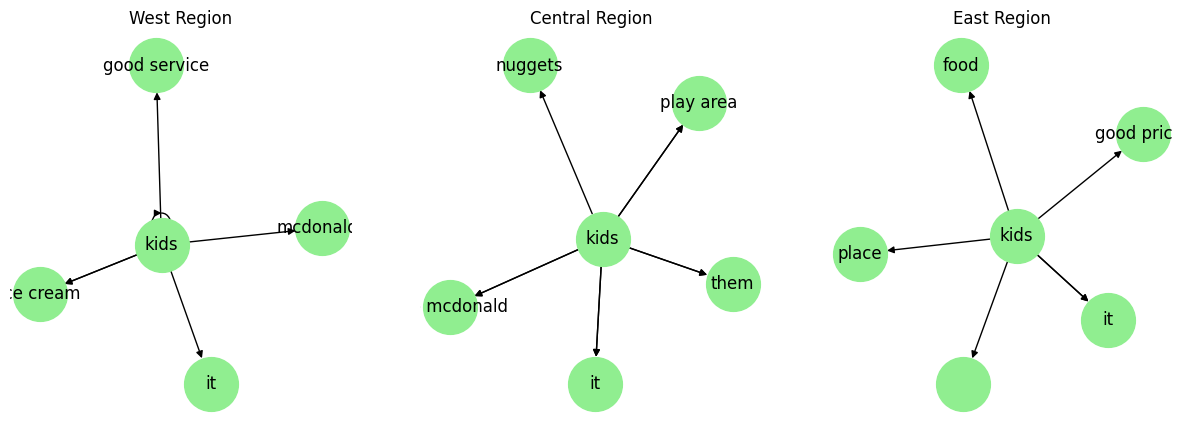

In [34]:
f, ax = plt.subplots(1, 3, figsize = (15, 5))
axx = ax.flatten()


# West Region
KG_rel = nx.from_pandas_edgelist(kg_df_west[(kg_df_west['edge']=="love") & (kg_df_west['source'] == 'kids')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[0])
_ = axx[0].set_title('West Region')

# Central Region
KG_rel = nx.from_pandas_edgelist(kg_df_central[(kg_df_central['edge']=="love") & (kg_df_central['source'] == 'kids')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[1])
_ = axx[1].set_title('Central Region')


# East Region
KG_rel = nx.from_pandas_edgelist(kg_df_east[(kg_df_east['edge']=="love") & (kg_df_east['source'] == 'kids')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[2])
_ = axx[2].set_title('East Region')


### Source = 'i', Edge = 'Love', 'hate'

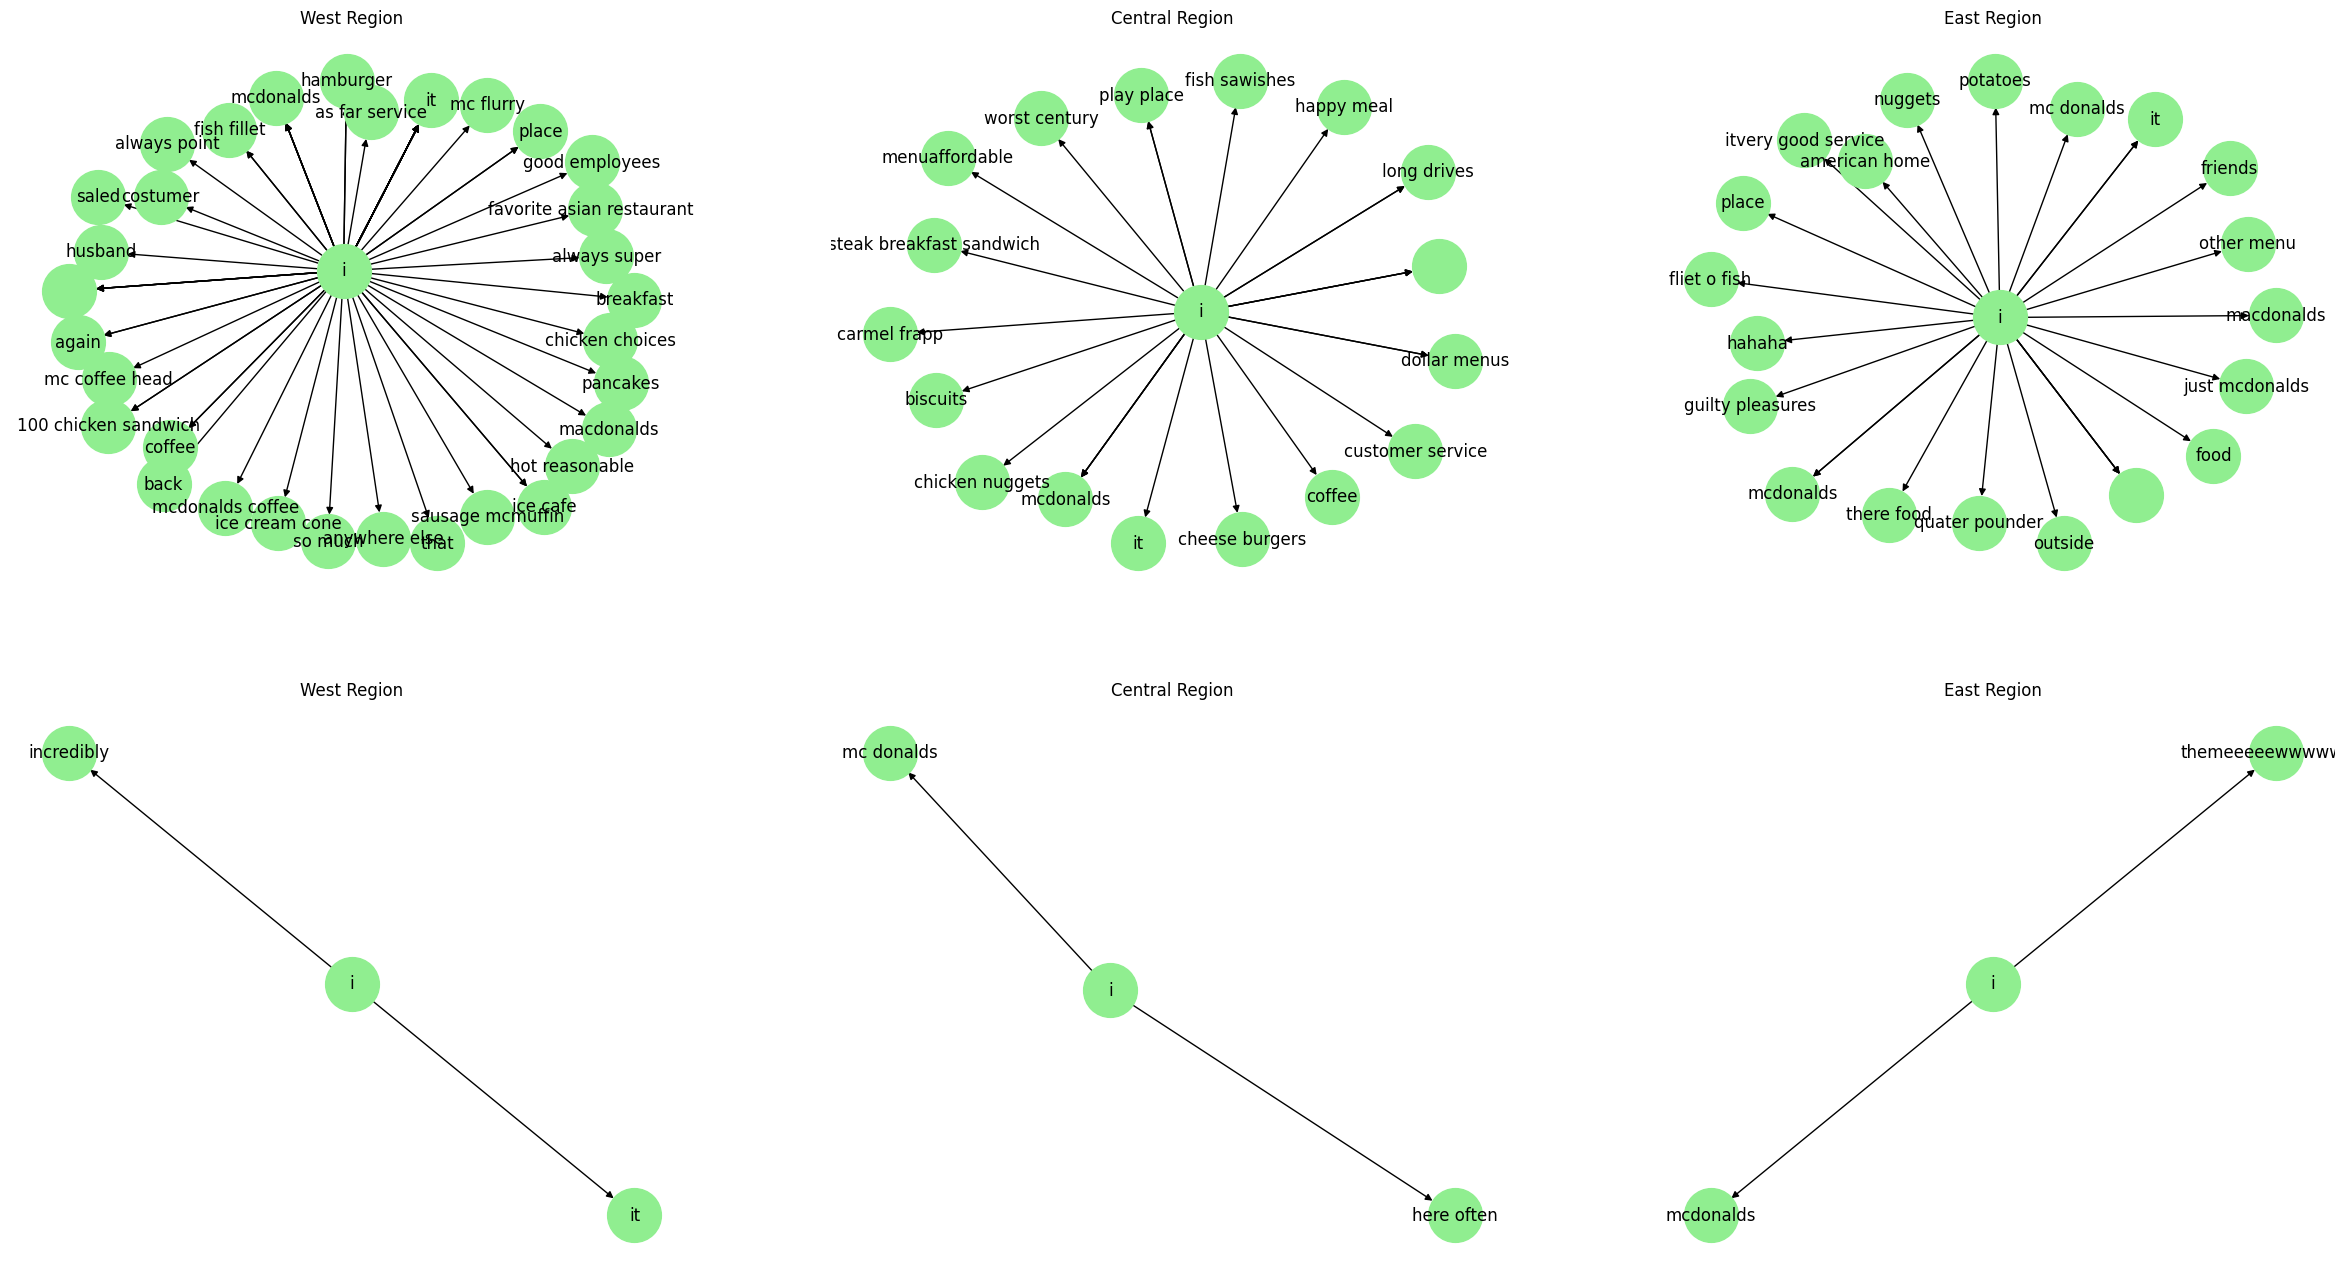

In [39]:
f, ax = plt.subplots(2, 3,  figsize = (30, 16))
axx = ax.flatten()


# West Region
KG_rel = nx.from_pandas_edgelist(kg_df_west[(kg_df_west['edge']=="love") & (kg_df_west['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[0])
_ = axx[0].set_title('West Region')

# Central Region
KG_rel = nx.from_pandas_edgelist(kg_df_central[(kg_df_central['edge']=="love") & (kg_df_central['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[1])
_ = axx[1].set_title('Central Region')


# East Region
KG_rel = nx.from_pandas_edgelist(kg_df_east[(kg_df_east['edge']=="love") & (kg_df_east['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[2])
_ = axx[2].set_title('East Region')


# West Region
KG_rel = nx.from_pandas_edgelist(kg_df_west[(kg_df_west['edge']=="hate") & (kg_df_west['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[3])
_ = axx[3].set_title('West Region')

# Central Region
KG_rel = nx.from_pandas_edgelist(kg_df_central[(kg_df_central['edge']=="hate") & (kg_df_central['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[4])
_ = axx[4].set_title('Central Region')


# East Region
KG_rel = nx.from_pandas_edgelist(kg_df_east[(kg_df_east['edge']=="hate") & (kg_df_east['source'] == 'i')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[5])
_ = axx[5].set_title('East Region')

### Source = 'mcdonalds', Edge = 'is'

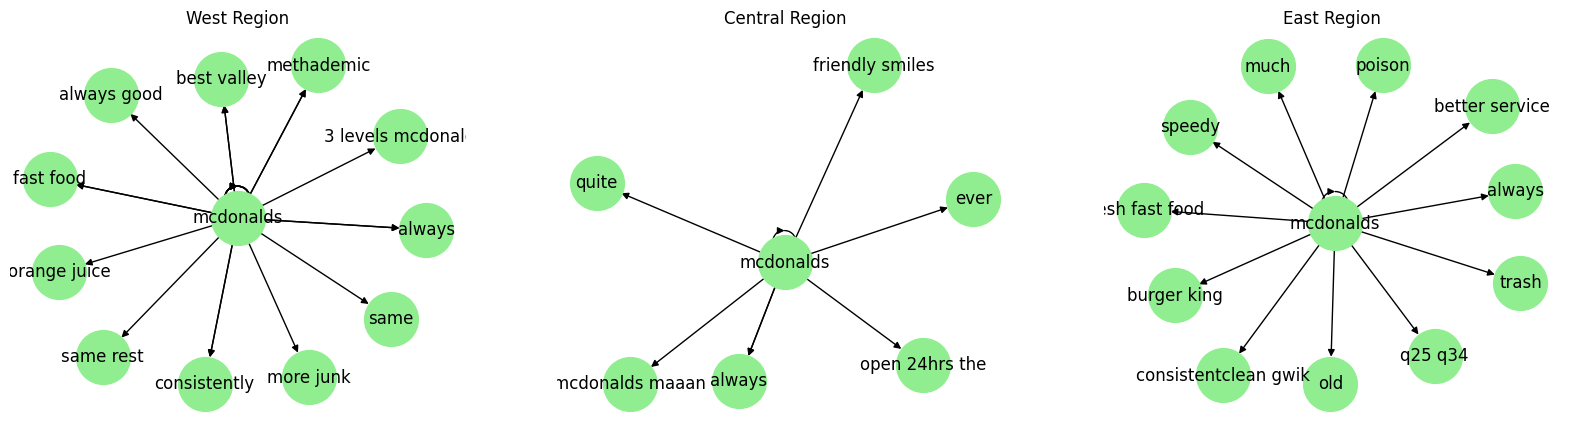

In [42]:
f, ax = plt.subplots(1, 3, figsize = (20, 5))
axx = ax.flatten()


# West Region
KG_rel = nx.from_pandas_edgelist(kg_df_west[(kg_df_west['edge']=="is") & (kg_df_west['source'] == 'mcdonalds')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[0])
_ = axx[0].set_title('West Region')

# Central Region
KG_rel = nx.from_pandas_edgelist(kg_df_central[(kg_df_central['edge']=="is") & (kg_df_central['source'] == 'mcdonalds')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[1])
_ = axx[1].set_title('Central Region')


# East Region
KG_rel = nx.from_pandas_edgelist(kg_df_east[(kg_df_east['edge']=="is") & (kg_df_east['source'] == 'mcdonalds')], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
_ = nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, ax = axx[2])
_ = axx[2].set_title('East Region')
